In [10]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans

from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster import SilhouetteVisualizer

from collections import Counter 
from sklearn.metrics import silhouette_samples, silhouette_score
import os
import random
import re

import time

import multiprocessing as mp

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [11]:
df = pd.read_pickle('../../data/p_comment.pkl.zip')
df1 = df[['ID_Posting','ID_GodotObject','p_merged_text']]
print(df1.shape)
print(df1.dtypes)
df1.head()

(421572, 3)
ID_Posting         int64
ID_GodotObject     int64
p_merged_text     object
dtype: object


,ID_Posting,ID_GodotObject,p_merged_text
0,1049737336,2000114365338,Virus wohl ansteckend denken wohl wirklich Luf...
1,1049737620,2000114365338,somit bestimmen deutlich mehr Mensch China inf...
2,1049737708,2000114365338,Horrorvorstellung Final Destination x
3,1049737722,2000114365338,sein interessant wissen schon krank schwächen ...
4,1049737801,2000114365338,gut Häfn


In [12]:
def vectorize_mean(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                vectors.append(model.wv[token])
        if vectors:
            vectors = np.asarray(vectors)
            mean_vec = vectors.mean(axis=0)
            features.append(mean_vec)
        else:
            features.append(zero_vector)
    return features

In [13]:
start = time.time()
tokenized_docs = df1["p_merged_text"].map(lambda x: str(x).split())
model = Word2Vec(sentences=tokenized_docs, vector_size=50, workers=20, seed=42)
vectorized_docs = vectorize_mean(tokenized_docs, model=model)
end = time.time()
print('processing time: ', end-start)

processing time:  53.40687322616577


C:\Users\e11925939\AppData\Local\Temp\8\ipykernel_24608\1353866477.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


ValueError: zero-size array to reduction operation fmin which has no identity

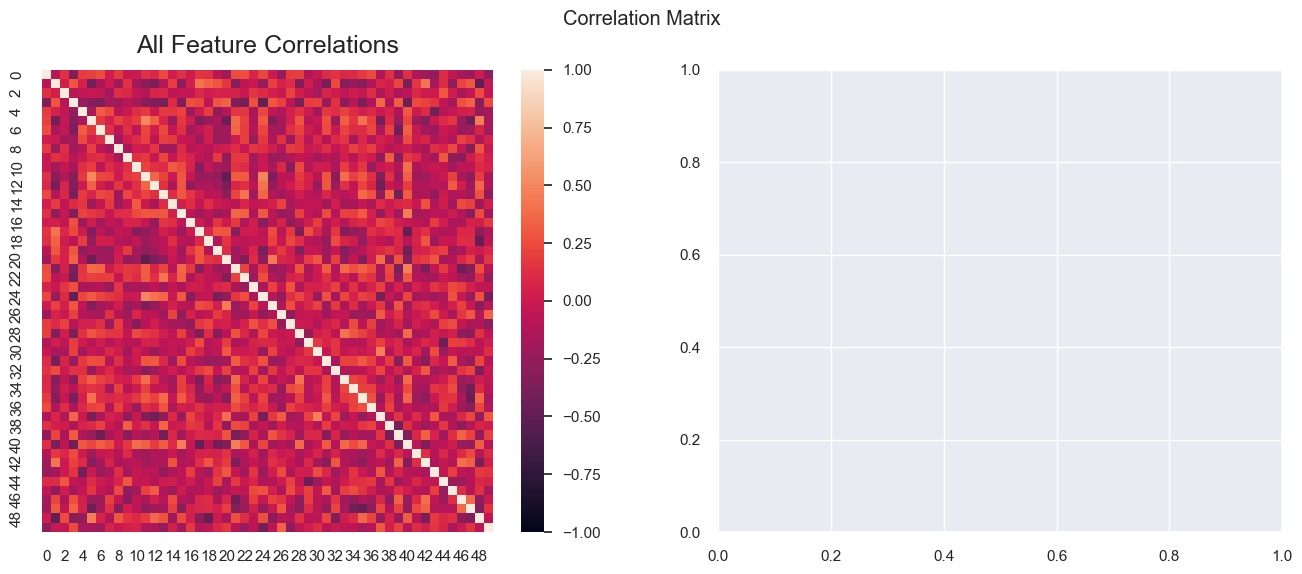

In [14]:
sns.set()

vectorized_docs_df = pd.DataFrame(vectorized_docs)
corr_matrix = vectorized_docs_df.corr().abs()


# Find the columns that have a correlation greater than 0.9
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

#high_corr_hm = sns.heatmap(high_corr), vmin=-1, vmax=1, cmap='BrBG')

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plt.suptitle("Correlation Matrix")
sns.heatmap(vectorized_docs_df.corr(), vmin=-1, vmax=1,ax=axs[0])
axs[0].set_title('All Feature Correlations', fontdict={'fontsize':18}, pad=12)
sns.heatmap(vectorized_docs_df[to_drop].corr(),ax=axs[1])
axs[1].set_title('Multicollinearity within ' + str(len(to_drop)) + ' features', fontdict={'fontsize':18}, pad=12)

#drop columns from dataset
vectorized_docs_df = vectorized_docs_df.drop(columns=to_drop)

plt.tight_layout()
plt.savefig("word2vec-heatmap.png", facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)

For n_clusters = 2 The average silhouette_score is : 0.11560185776909856


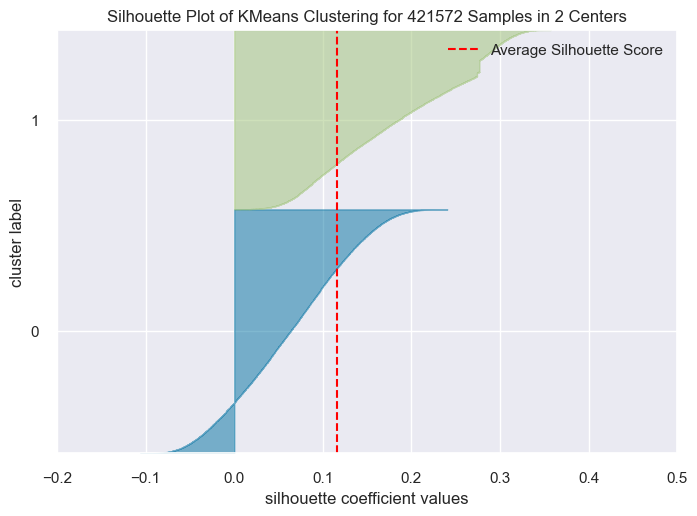

For n_clusters = 3 The average silhouette_score is : 0.10081049655630447


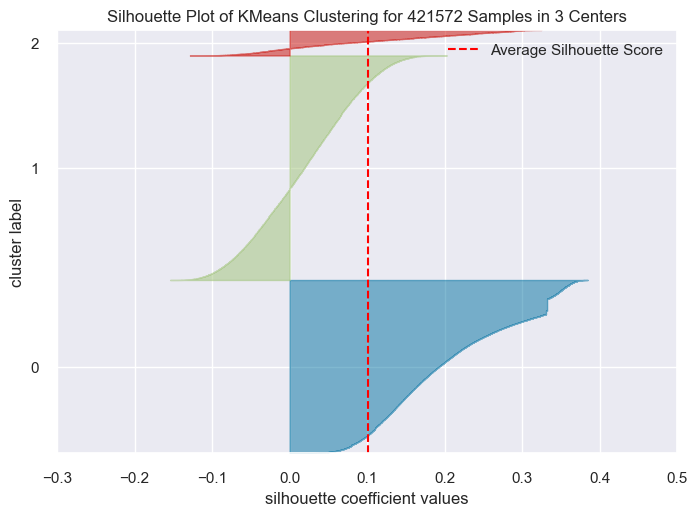

For n_clusters = 4 The average silhouette_score is : 0.09728957793401077


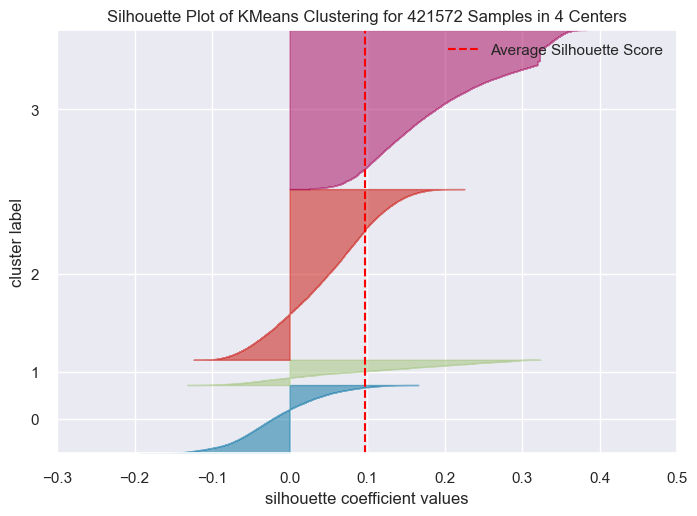

For n_clusters = 5 The average silhouette_score is : 0.07865496671774672


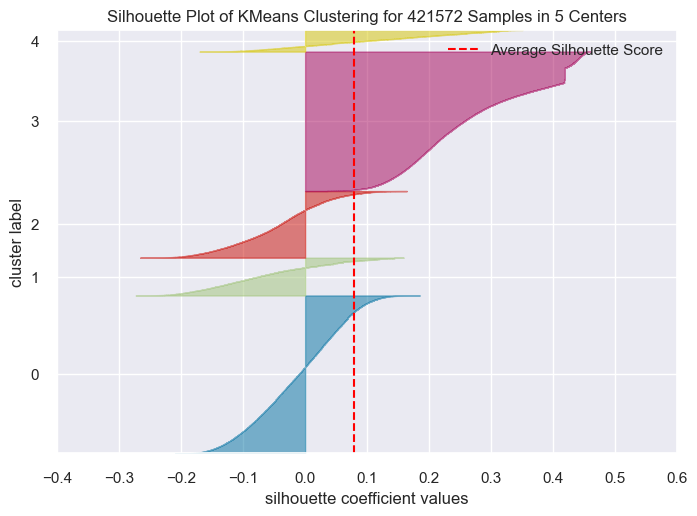

For n_clusters = 6 The average silhouette_score is : 0.07584647213348238


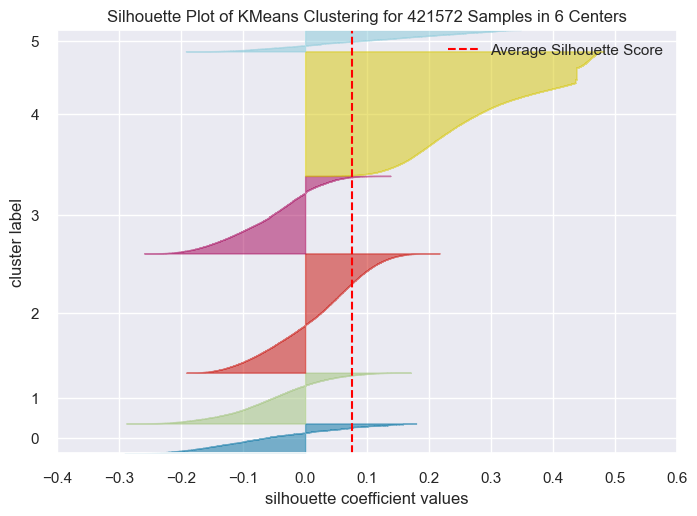

For n_clusters = 7 The average silhouette_score is : 0.05129969105461579


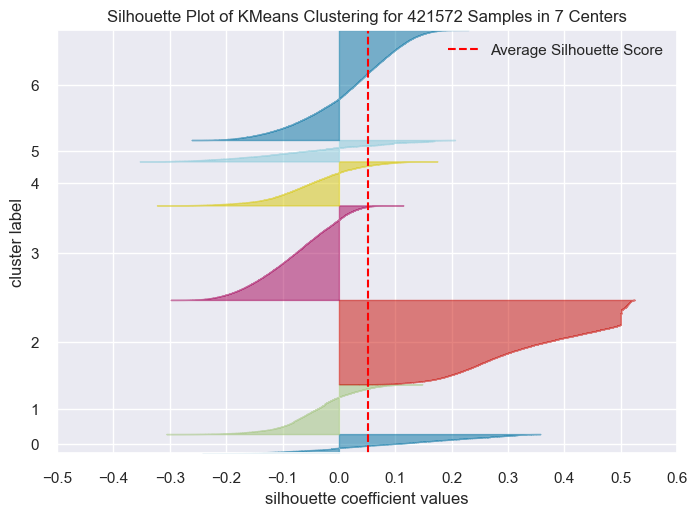

For n_clusters = 8 The average silhouette_score is : 0.050579557133548135


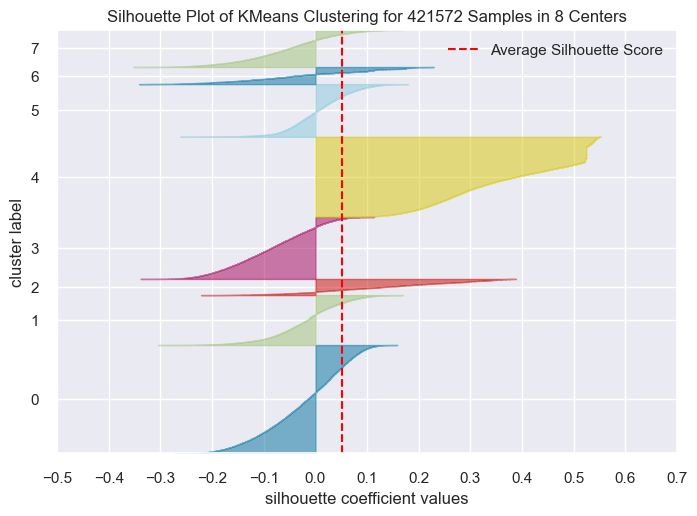

For n_clusters = 9 The average silhouette_score is : 0.03987742927170769


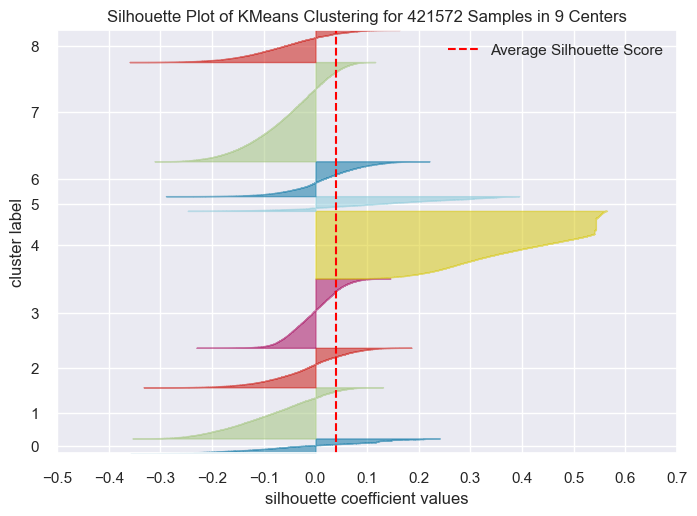

For n_clusters = 10 The average silhouette_score is : 0.03001049846309638


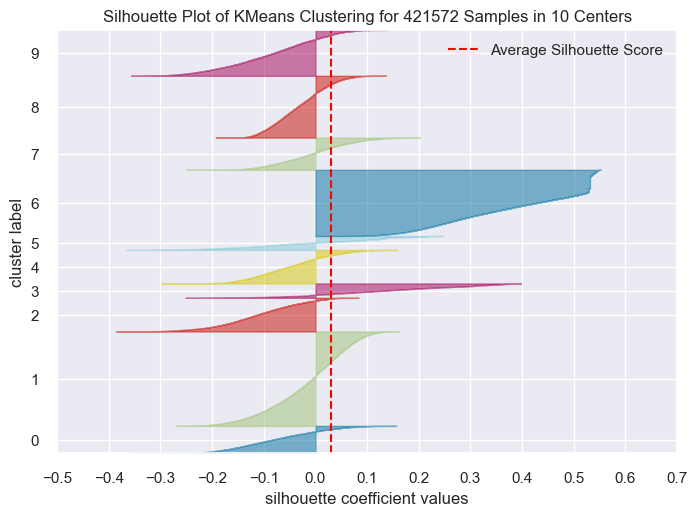

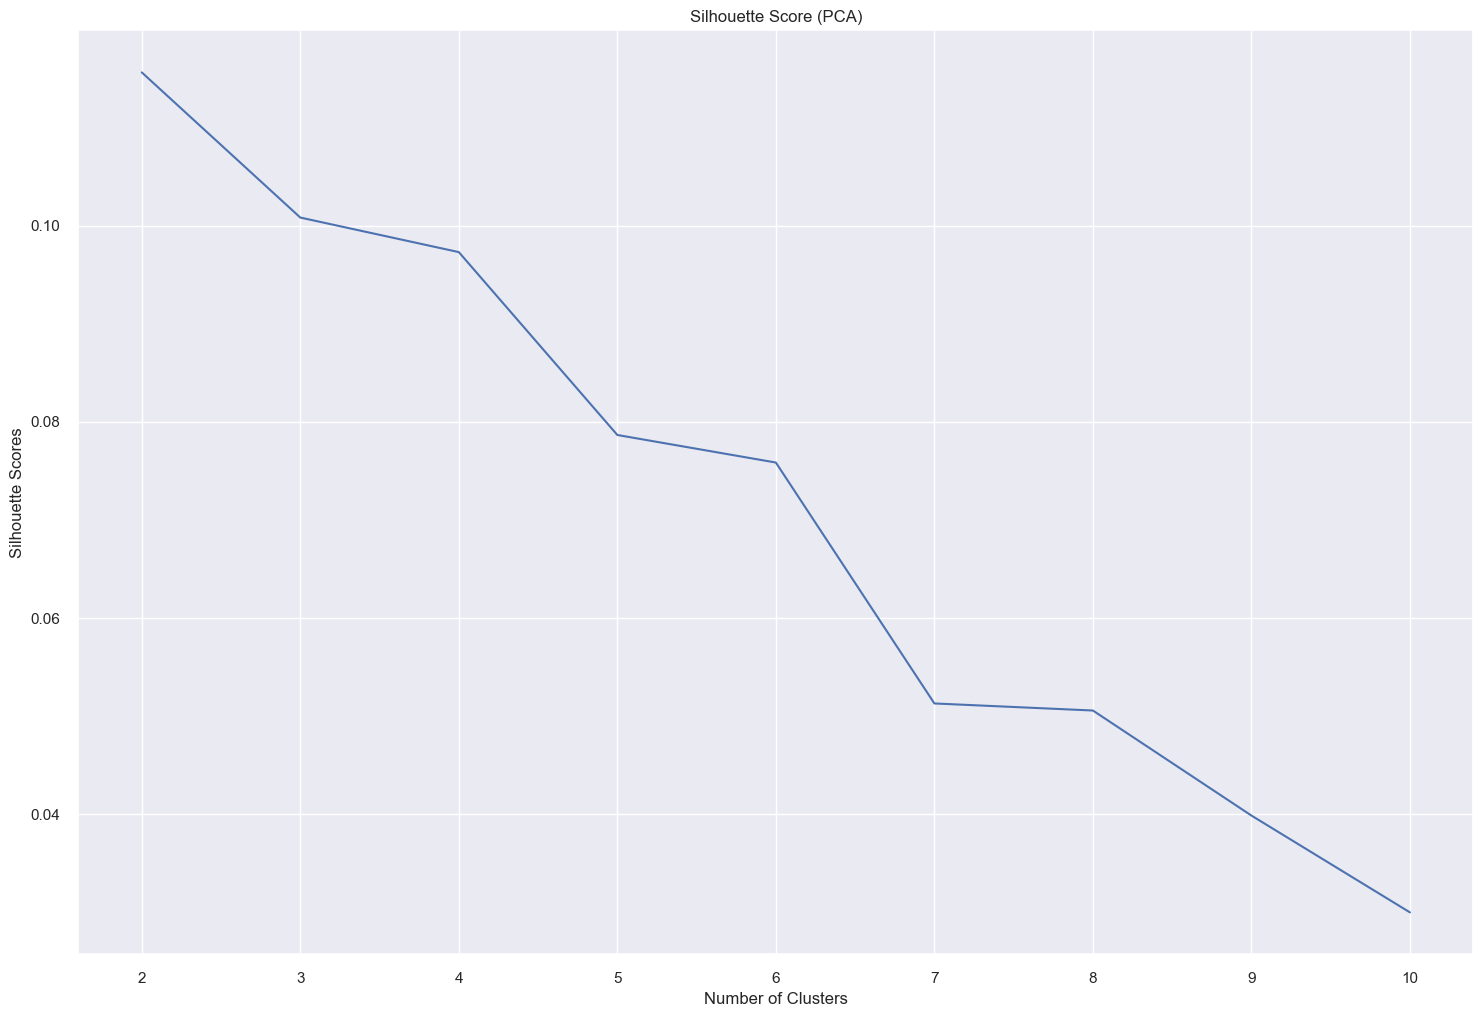

In [15]:
sc = StandardScaler()
X = sc.fit_transform(vectorized_docs_df.to_numpy())

rs = 42

#knn_per_k = [KMeans(n_clusters = n, random_state=rs).fit(X) for n in range(1, 10)]
#ilhouette_scores = [silhouette_score(scaled_data, model.labels_) or model in kmeans_per_k[1:]]
trained_models = {}
sil_scores = []
r = range(2, 11)
for k in r:
    model = KMeans(n_clusters=k, n_init=10, random_state=rs)
    labels = model.fit_predict(X)
    trained_models[k] = (model, labels)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, labels)
    sil_scores.append(silhouette_avg)
    print(
        "For n_clusters =",
        k,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    silhouette_visualizer(model, X, colors='yellowbrick')
    
    
#visualization
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
x = 0
y = 0
for i in range(3,7):
    visualizer = SilhouetteVisualizer(trained_models[i][0], colors='yellowbrick', ax=ax[y,x])
    visualizer.fit(X)        
    visualizer.finalize()        
    x += 1
    if x == 2:
        x = 0
        y += 1
    
    
plt.savefig("c_word2vec-knn-silhoutte.png", facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)


plt.clf()

plt.plot(r, sil_scores)

# Label the axes
plt.xlabel('Number of Clusters')
plt.title('Silhouette Score (PCA)')
plt.ylabel('Silhouette Scores')
plt.savefig("c_word2vec-silhoutte-scores.png", facecolor=fig.get_facecolor(), edgecolor='none', dpi=300)
# Show the plot
plt.show()
